### Libraries

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import os 
import scipy 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Import Data

In [297]:
data_dir = "/Users/taw/dev/upwork/telnyx/data/"

# importing telnyx data 

tlnx_cols = [
       'caller', 'callee', 'callee_LRN', 'timestamp', 'billedduration',
       'billed_rate', 'billed_cost']
df_tlnx = pd.read_csv(os.path.join(data_dir,'telnyx.csv'), names = tlnx_cols)
df_tlnx.timestamp = pd.to_datetime(df_tlnx.timestamp)                                                           # convert timestamp object datatype to timestamp
df_tlnx.callee = df_tlnx.callee.astype(str).str.slice(-10)
df_tlnx.caller = df_tlnx.caller.astype(str).str.slice(-10)
df_tlnx.callee_LRN = df_tlnx.callee_LRN.astype(str)
df_tlnx.head(1)

,caller,callee,callee_LRN,timestamp,billedduration,billed_rate,billed_cost
0,9785108014,9543063291,1954990,2017-09-11 14:30:02,6,0.00266,0.0003


In [298]:
# importing vendor data 

vendor_cols = [
       'caller', 'callee', 'timestamp', 'callee_LRN', 'billedduration',
       'billed_rate', 'billed_cost']

df_vendor = pd.read_csv(os.path.join(data_dir,'vendor.csv'), names = vendor_cols)
df_vendor.timestamp = pd.to_datetime(df_vendor.timestamp)                                                        # convert timestamp object datatype to timestamp
df_vendor.callee = df_vendor.callee.astype(str).str.slice(-10)
df_vendor.caller = df_vendor.caller.astype(str).str.slice(-10)

df_vendor.head(1)

,caller,callee,timestamp,callee_LRN,billedduration,billed_rate,billed_cost
0,3027158701,2012000010,2017-09-15 16:54:40,1.201821e+10,18,0.00415,0.0013


In [299]:
# Seperating LRN into actual LRN used for billing and area code
# min calle LRN = 2 ; max calle LRM = 10 --> issue this discrepancy

df_vendor.callee_LRN = df_vendor.callee_LRN.astype(str).str[1:11]
df_vendor['callee_arc'] = df_vendor.callee_LRN.str[0:6]
df_vendor['caller_arc'] = df_vendor.caller.str[0:6]
df_vendor.head(1)

,caller,callee,timestamp,callee_LRN,billedduration,billed_rate,billed_cost,callee_arc,caller_arc
0,3027158701,2012000010,2017-09-15 16:54:40,2018209999,18,0.00415,0.0013,201820,302715


In [300]:
code_cols = ['area_code', 'area']
df_arc = pd.read_csv(os.path.join(data_dir,'area_codes.csv'), names = code_cols)
df_arc.area_code = df_arc.area_code.astype(str).str.slice(-6)
df_arc.head(1)

,area_code,area
0,201007,NJ


### Exploratory Data Analysis

In [11]:
print("Number of Telnyx CDRs {}".format(len(df_tlnx)))
print("Number of Vendor CDRs {}".format(len(df_vendor)))

Number of Telnyx CDRs 9983181
Number of Vendor CDRs 9998099


In [301]:
print("Distinct Number of Callee LRNs in Telnyx CDRs {}".format(df_tlnx['callee_LRN'].nunique()-1)) # removing NaN count
print("Distinct Number of Callee LRNs in Vendor CDRs {}".format(df_vendor['callee_LRN'].nunique()-1))

Distinct Number of Callee LRNs in Telnyx CDRs 93131
Distinct Number of Callee LRNs in Vendor CDRs 19905


### Mispriced Call Table

#### Generate CRD IDS

In [13]:
# Generate Unique CRD identifier for caller, callee and timestamp

import hashlib

def generate_id(caller_id, callee_id, timestamp):
    # Concatenate the values into a string
    values = str(caller_id) + str(callee_id) + str(timestamp)
    
    # Hash the string using SHA-256 algorithm
    hash_obj = hashlib.sha256(values.encode('utf-8'))
    hash_hex = hash_obj.hexdigest()
    
    # Return the first 16 characters of the hash as the unique identifier
    return hash_hex[:16]

In [14]:
# set all timestamps to the nearest tens place; might result in some duplicates. but by far the best

df_tlnx['timestamp_'] = df_tlnx.timestamp.round('10S')
df_vendor['timestamp_'] = df_vendor.timestamp.round('10S')

In [17]:
# Check for id discrepancies 

print("Maximum No of telnyx caller ids {}".format(max(df_tlnx.caller.astype(str).str.len())))
print("Minimum No of telnyx caller ids {}".format(min(df_tlnx.caller.astype(str).str.len())))
print("Maximum No of Vendor caller ids {}".format(max(df_vendor.caller.astype(str).str.len())))
print("Minimum No of Vendor caller ids {}".format(min(df_vendor.caller.astype(str).str.len())))


print("Maximum No of telnyx callee ids {}".format(max(df_tlnx.callee.astype(str).str.len())))
print("Minimum No of telnyx callee ids {}".format(min(df_tlnx.callee.astype(str).str.len())))
print("Maximum No of Vendor callee ids {}".format(max(df_vendor.callee.astype(str).str.len())))
print("Minimum No of Vendor callee ids {}".format(min(df_vendor.callee.astype(str).str.len())))

Maximum No of telnyx caller ids 10
Minimum No of telnyx caller ids 10
Maximum No of Vendor caller ids 10
Minimum No of Vendor caller ids 10
Maximum No of telnyx callee ids 10
Minimum No of telnyx callee ids 10
Maximum No of Vendor callee ids 10
Minimum No of Vendor callee ids 10


!! No ID discrepancies

In [18]:
# applying the hash id generator in each CRD database
# this run might take 5+ minutes 
df_tlnx['id'] = df_tlnx.apply(lambda x: generate_id(x['caller'],x['callee'],x['timestamp_']), axis=1)
df_vendor['id'] = df_vendor.apply(lambda x: generate_id(x['caller'],x['callee'],x['timestamp_']), axis=1)
df_tlnx.head(1)

,caller,callee,callee_LRN,timestamp,billedduration,billed_rate,billed_cost,timestamp_,id
0,9785108014,9543063291,1954990,2017-09-11 14:30:02,6,0.00266,0.0003,2017-09-11 14:30:00,a97e140f6a66b694


**Verification**

In [19]:
vendor_dups = df_vendor[['id', 'caller']].groupby(by='id').count()['caller'].reset_index()
print("Duplicate Vendor CDR ID Percentage {}".format(round(len(vendor_dups[vendor_dups.caller > 1])/len(vendor_dups) * 100,4)))


tlnx_dups = df_tlnx[['id', 'caller']].groupby(by='id').count()['caller'].reset_index()
print("Duplicate Tenlyx CDR ID Percentage {}".format(round(len(tlnx_dups[tlnx_dups.caller > 1])/len(tlnx_dups) * 100,4)))

Duplicate Vendor CDR ID Percentage 0.0175
Duplicate Tenlyx CDR ID Percentage 0.0068


!! Ignoring these duplicate ids as they are less significant in percentage. 

In [20]:
output_dir = "/Users/taw/dev/upwork/telnyx/output/"

# removing truncated timestamp_ column 
df_tlnx = df_tlnx.drop(['timestamp_'], axis=1)
df_vendor = df_vendor.drop(['timestamp_'], axis=1)

# output the dataframe to a CSV file 
df_tlnx.to_csv(os.path.join(output_dir, 'telnyx_preprocessed.csv') , index=False)
df_vendor.to_csv(os.path.join(output_dir, 'vendor_preprocessed.csv') , index=False)

### Importing Preprocessed Telnyx & Vendor Data

In [81]:

"""
df_tlnx = pd.read_csv("/Users/taw/dev/upwork/telnyx/output/telnyx_preprocessed.csv")
df_vendor = pd.read_csv("/Users/taw/dev/upwork/telnyx/output/vendor_preprocessed.csv")

# using dictionary to convert specific columns
convert_dict = {'caller': str,
                'callee': str,
                'callee_LRN' : str
                }
 
df_vendor.timestamp = pd.to_datetime(df_vendor.timestamp)  
df_vendor.caller_arc = df_vendor.caller_arc.astype(str)

df_tlnx.timestamp = pd.to_datetime(df_tlnx.timestamp)  

df_vendor = df_vendor.astype(convert_dict)
df_tlnx = df_tlnx.astype(convert_dict)

"""


We've successfully mapped caller, callee and timestamp into a unique ID using SHA-256 algorithm

#### Misplaced CRD Tables

**Bill Duration Discrepancies**

In [21]:
t_bill = df_tlnx.merge(df_vendor, how='inner', on='id')[['id', 'billedduration_x', 'billedduration_y']]
t_bill.columns = ['id', 'billduration_tlnx', 'billduration_vendor']
error_bills = t_bill[t_bill.billduration_tlnx != t_bill.billduration_vendor].sort_values('billduration_tlnx', ascending=False)

error_count =  error_bills.id.nunique()

print("Total CRD Counts {}".format(len(t_bill)))
print("Total CRDs having Bill Duration Discrepancies {}".format(error_count))
print("Percentage Errors {}".format(str(round(error_count/len(t_bill) * 100, 2)) + '%'))

Total CRD Counts 9755045
Total CRDs having Bill Duration Discrepancies 255723
Percentage Errors 2.62%


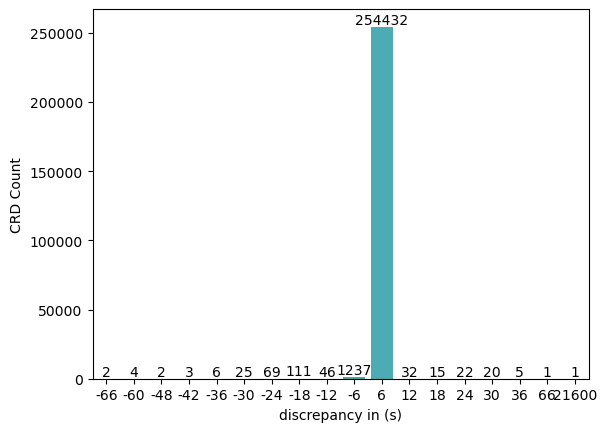

In [22]:
error_bills['gap'] = error_bills.billduration_vendor - error_bills.billduration_tlnx
gap_plot = pd.DataFrame(error_bills.groupby(by='gap').count()['id']).reset_index()


# plot bar 
ax = sns.barplot(x = 'gap',y = 'id',data = gap_plot,errwidth=0, orient='v')

ax.bar_label(ax.containers[0])
ax.set_xlabel('discrepancy in (s)')
ax.set_ylabel('CRD Count')
plt.show()

Note : Most of the discrepancies associated with bill duration is with 6s difference. 

In [36]:
#  Duration Discrepancy CRD Records Area 
CRD_area = df_vendor.merge(error_bills, on='id', how='inner')[['id', 'callee_arc', 'caller_arc']]
print("% Null Callee Area Codes {}".format(round(len(CRD_area[CRD_area.callee_arc == 'an'])/len(CRD_area) * 100 , 2 ) )) 

CRD_area = CRD_area[CRD_area.callee_arc != 'an']
CRD_area.dropna(axis=0, inplace=True)
CRD_area['calle_area'] = CRD_area['callee_arc'].map(df_arc.set_index('area_code')['area'])
CRD_area['caller_area'] = CRD_area['caller_arc'].map(df_arc.set_index('area_code')['area'])
CRD_area['inter_state'] = CRD_area.calle_area == CRD_area.caller_area

CRD_area.head(1)

% Null Callee Area Codes 35.32


,id,callee_arc,caller_arc,calle_area,caller_area,inter_state
0,d4e1211ff912a9ea,201820,978510,NJ,MA,False


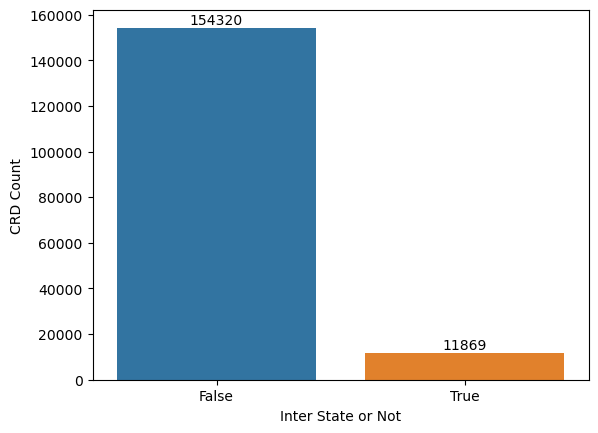

In [55]:
plot_df = pd.DataFrame(CRD_area.inter_state.value_counts()).reset_index()
plot_df.columns = ['inter_state_bool', 'count_ids']

# plot bar 
ax = sns.barplot(x = 'inter_state_bool',y = 'count_ids',data = plot_df, errwidth=0, orient='v')

ax.bar_label(ax.containers[0])
ax.set_xlabel('Inter State or Not')
ax.set_ylabel('CRD Count')
plt.show()

!!! Max Billed Duration Discrepancies are from Intra State Calls

**Billed LRN Discrepancy Check**

In [86]:
# replace all the LRNs into identical format

df_tlnx.callee_LRN = df_tlnx.callee_LRN.str.slice(-6)
df_vendor.callee_LRN = df_vendor.callee.str[:6]

In [99]:
df_lrn = df_tlnx.merge(df_vendor, on='id', how='inner')[['id', 'callee_LRN_x', 'callee_LRN_y']]
df_lrn.sample(1)

,id,callee_LRN_x,callee_LRN_y
3167508,86e57a839ef36329,302604,484562


In [100]:
df_lrn.columns = ['id', 'tlnx_LRN', 'vendor_LRN']
df_lrn['is_correct'] = df_lrn.tlnx_LRN == df_lrn.vendor_LRN
df_lrn = df_lrn.drop_duplicates()
df_lrn.head()

,id,tlnx_LRN,vendor_LRN,is_correct
0,a97e140f6a66b694,954990,954306,False
1,7d540214e05994f5,954229,954229,True
2,d08b5871d17b89e7,954282,954282,True
3,d3849d92155d4eab,786930,954251,False
4,93e0d76f139b0b37,786930,954256,False


In [120]:
df_lrn.is_correct.value_counts()

False    5471515
True     4280561
Name: is_correct, dtype: int64

In [133]:
print("Percentage of LRN Errors {}".format(str(round ( len(df_lrn[df_lrn['is_correct'] == False]) / len(df_lrn) * 100, 2 ) ) + '%')) 

Percentage of LRN Errors 56.11%


!! Approximately 56.11% LRNs in the Telnyx Table has error in callee LRN

In [110]:
df_tlnx[df_tlnx.id == 'd3849d92155d4eab']

,caller,callee,callee_LRN,timestamp,billedduration,billed_rate,billed_cost,id
3,9785108014,9542510030,786930,2017-09-11 14:30:01,6,0.00354,0.0004,d3849d92155d4eab


In [111]:
df_vendor[df_vendor.id == 'd3849d92155d4eab']

,caller,callee,timestamp,callee_LRN,billedduration,billed_rate,billed_cost,callee_arc,caller_arc,id
9642688,9785108014,9542510030,2017-09-11 14:30:01,954251,6,0.00354,0.0004,786930,978510,d3849d92155d4eab


!! See that in Telnyx table callee LRN parsing is wrong...

**Rounding Error in Billed Amount**

In [177]:
def normal_round(num, ndigits=0):
    """
    Rounds a float to the specified number of decimal places.
    num: the value to round
    ndigits: the number of digits to round to
    """
    
    if ndigits == 0:
        return int(num + 0.5)
    else:
        digit_value = 10 ** ndigits
        return int(num * digit_value + 0.5) / digit_value

In [195]:
df_tlnx_temp = df_tlnx.copy()

df_tlnx_temp['calc_billed_cost'] = df_tlnx_temp.billedduration / 60 * df_tlnx_temp.billed_rate
df_tlnx_temp['calc_billed_cost'] = df_tlnx_temp.apply(lambda x: normal_round(x.calc_billed_cost,4), axis=1)
df_tlnx_temp['tlnx_billed_cost'] = df_tlnx_temp.apply(lambda x: normal_round(x.billed_cost,4), axis=1)
df_tlnx_temp['is_correct'] = df_tlnx_temp['calc_billed_cost'] == df_tlnx_temp['tlnx_billed_cost']

print (" Out of {} CRDs {} has rounding errors in Telnyx CRDs ".format(len(df_tlnx_temp), df_tlnx_temp.is_correct.value_counts()[1]))
print (" Percentage rounding errors in Telnyx CRDs {}".format(str(round(df_tlnx_temp.is_correct.value_counts()[1] / len(df_tlnx_temp)  * 100 , 2)) + '%'))


round_err_df = df_tlnx_temp[df_tlnx_temp.is_correct != True]
round_err_df.head(1)

 Out of 9983181 CRDs 189288 has rounding errors in Telnyx CRDs 
 Percentage rounding errors in Telnyx CRDs 1.9%


,caller,callee,callee_LRN,timestamp,billedduration,billed_rate,billed_cost,id,calc_billed_cost,tlnx_billed_cost,is_correct
41,9785108014,9542833362,954283,2017-09-11 14:30:03,12,0.00225,0.0005,e5b74531b5f3ba69,0.0004,0.0005,False


In [241]:
df_vendor_temp = df_vendor.copy()

df_vendor_temp['calc_billed_cost'] = df_vendor_temp.billedduration / 60 * df_vendor_temp.billed_rate
df_vendor_temp['calc_billed_cost'] = df_vendor_temp.apply(lambda x: round(x.calc_billed_cost,4), axis=1)
df_vendor_temp['tlnx_billed_cost'] = df_vendor_temp.apply(lambda x: round(x.billed_cost,4), axis=1)
df_vendor_temp['is_correct'] = df_vendor_temp['calc_billed_cost'] == df_vendor_temp['tlnx_billed_cost']

print (" Out of {} CRDs {} has rounding errors in Vendor CRDs ".format(len(df_vendor_temp), df_vendor_temp.is_correct.value_counts()[1]))
print (" Percentage rounding errors in Vendor CRDs {}".format(str(round(df_vendor_temp.is_correct.value_counts()[1] / len(df_vendor_temp)  * 100 , 2)) + '%'))


 Out of 9998099 CRDs 4954408 has rounding errors in Vendor CRDs 
 Percentage rounding errors in Vendor CRDs 49.55%


In [200]:
print("Total Bill Difference {}".format(str(round(sum(abs(round_err_df.tlnx_billed_cost - round_err_df.calc_billed_cost)),2)) + "$"))  

Total Bill Difference 18.93$


**Wrong Rate Deck Error**

In [ ]:
df_vendor['calle_area'] = df_vendor['callee_arc'].map(df_arc.set_index('area_code')['area'])
df_vendor['caller_area'] = df_vendor['caller_arc'].map(df_arc.set_index('area_code')['area'])
df_vendor['is_inter_state'] = df_vendor['calle_area'] != df_vendor['caller_area']

In [222]:
rate_err_df = df_tlnx.merge(df_vendor, on='id', how='inner')[['id', 'billed_rate_x', 'billed_rate_y', 'is_inter_state']]
rate_err_df.columns =  ['id', 'billed_rate_tlnx', 'billed_rate_vendor', 'is_inter_state']

rate_err_df['billed_rate_tlnx'] = rate_err_df.apply(lambda x: normal_round(x.billed_rate_tlnx,5), axis=1)
rate_err_df['billed_rate_vendor'] = rate_err_df.apply(lambda x: normal_round(x.billed_rate_vendor,5), axis=1)
rate_err_df['is_correct'] =  rate_err_df.billed_rate_vendor == rate_err_df.billed_rate_tlnx
rate_err_df.sample(1)

,id,billed_rate_tlnx,billed_rate_vendor,is_inter_state
1576840,97a6b6dcefb0dfac,0.00375,0.00375,True


In [229]:
print (" Out of {} CRDs {} has wrong deck errors in CRDs ".format(len(rate_err_df), rate_err_df.is_correct.value_counts()[1]))
print (" Percentage wrong rate deck errors in CRDs {}".format(str(round(rate_err_df.is_correct.value_counts()[1] / len(rate_err_df)  * 100 , 2)) + '%'))

 Out of 9755045 CRDs 1176032 has wrong deck errors in CRDs 
 Percentage wrong rate deck errors in CRDs 12.06%


In [236]:
print("Intra State Wrong Deck Error Count {} \nPercentage {} of All errors".format(
    rate_err_df[rate_err_df.is_correct == False].is_inter_state.value_counts()[1],
    str(round(rate_err_df[rate_err_df.is_correct == False].is_inter_state.value_counts()[1] / len(rate_err_df[rate_err_df.is_correct == False]) * 100,2)) + "%"
))

print("Inter State Wrong Deck Error Count {} \nPercentage {} of All errors".format(
    rate_err_df[rate_err_df.is_correct == False].is_inter_state.value_counts()[0],
    str(round(rate_err_df[rate_err_df.is_correct == False].is_inter_state.value_counts()[0] / len(rate_err_df[rate_err_df.is_correct == False]) * 100,2)) + "%"
))

#rate_err_df[rate_err_df.is_correct == False].is_inter_state.value_counts()[1]

Intra State Wrong Deck Error Count 352460 
Percentage 29.97% of All errors
Inter State Wrong Deck Error Count 823572 
Percentage 70.03% of All errors


!! Most of the wrong deck errors occured for inter state calls

###  Checking root-cause of errors

In [239]:
wrong_rate_deck_df =  rate_err_df[rate_err_df.is_correct == False]
wrong_round_df = round_err_df.copy()
wrong_duration_df = error_bills.copy()
wrong_lrn_df = df_lrn[df_lrn['is_correct'] == False]

In [250]:
df_tlnx_v2 = df_tlnx.copy()
df_tlnx_v2.columns = ['tlnx_caller', 'tlnx_callee', 'tlnx_callee_LRN', 'tlnx_timestamp', 'tlnx_billedduration',
       'tlnx_billed_rate', 'tlnx_billed_cost', 'id']


df_vendor_v2 = df_vendor.copy()
df_vendor_v2.columns  = ['vendor_caller', 'vendor_callee', 'vendor_timestamp', 'vendor_callee_LRN', 'vendor_billedduration',
       'vendor_billed_rate', 'vendor_billed_cost', 'vendor_callee_arc', 'vendor_caller_arc', 'id',
       'vendor_calle_area', 'vendor_caller_area', 'vendor_is_inter_state']

In [251]:
df_all = df_tlnx_v2.merge(df_vendor_v2, how='inner', on='id')

In [252]:
df_all.head(1)

,tlnx_caller,tlnx_callee,tlnx_callee_LRN,tlnx_timestamp,tlnx_billedduration,tlnx_billed_rate,tlnx_billed_cost,id,vendor_caller,vendor_callee,vendor_timestamp,vendor_callee_LRN,vendor_billedduration,vendor_billed_rate,vendor_billed_cost,vendor_callee_arc,vendor_caller_arc,vendor_calle_area,vendor_caller_area,vendor_is_inter_state
0,9785108014,9543063291,954990,2017-09-11 14:30:02,6,0.00266,0.0003,a97e140f6a66b694,9785108014,9543063291,2017-09-11 14:30:03,954306,6,0.00266,0.0003,954990,978510,FL,MA,True


In [253]:
df_all_v2 = df_all.copy()

"""df_all_v2['is_LRN_error'] = df_all_v2.apply(lambda x: x.tlnx_callee_LRN != x.vendor_callee_LRN, axis=1).astype(int)
df_all_v2['is_duration_error'] = df_all_v2.apply(lambda x: x.tlnx_billedduration != x.vendor_billedduration, axis=1).astype(int)
"""

df_all_v2['is_LRN_error'] = df_all_v2.tlnx_callee_LRN != df_all_v2.vendor_callee_LRN
df_all_v2['is_duration_error'] = df_all_v2.tlnx_billedduration != df_all_v2.vendor_billedduration

#rounding upto 5 decimal place for bill rate
df_all_v2['tlnx_billed_rate'] = df_all_v2.apply(lambda x: normal_round(x.tlnx_billed_rate,5), axis=1)
df_all_v2['vendor_billed_rate'] = df_all_v2.apply(lambda x: normal_round(x.vendor_billed_rate,5), axis=1)
df_all_v2['is_wrong_rate_deck_error'] = df_all_v2.tlnx_billed_rate != df_all_v2.vendor_billed_rate

#rounding upto 4 decimal place for bill rate
df_all_v2['vendor_billed_cost'] = df_all_v2.apply(lambda x: normal_round(x.vendor_billed_cost,5), axis=1)
df_all_v2['tlnx_billed_cost'] = df_all_v2.apply(lambda x: normal_round(x.tlnx_billed_cost,5), axis=1)
df_all_v2['is_rounding_error'] =  df_all_v2.vendor_billed_cost != df_all_v2.tlnx_billed_cost

In [254]:
df_all_v2.head(1)

,tlnx_caller,tlnx_callee,tlnx_callee_LRN,tlnx_timestamp,tlnx_billedduration,tlnx_billed_rate,tlnx_billed_cost,id,vendor_caller,vendor_callee,...,vendor_billed_cost,vendor_callee_arc,vendor_caller_arc,vendor_calle_area,vendor_caller_area,vendor_is_inter_state,is_LRN_error,is_duration_error,is_wrong_rate_deck_error,is_rounding_error
0,9785108014,9543063291,954990,2017-09-11 14:30:02,6,0.00266,0.0003,a97e140f6a66b694,9785108014,9543063291,...,0.0003,954990,978510,FL,MA,True,True,False,False,False


In [260]:
df_all_v2[['is_LRN_error', 'is_duration_error', 'is_wrong_rate_deck_error','is_rounding_error']] = df_all_v2[['is_LRN_error', 'is_duration_error', 'is_wrong_rate_deck_error','is_rounding_error']].astype(int)

df_all_v2['is_LRN_error'] = np.where(df_all_v2['is_LRN_error'], 'LRN Error', 'Correct')
df_all_v2['is_duration_error'] = np.where(df_all_v2['is_duration_error'], 'Duration Error', 'Correct')
df_all_v2['is_wrong_rate_deck_error'] = np.where(df_all_v2['is_wrong_rate_deck_error'], 'Wrong Rate Error', 'Correct')
df_all_v2['is_rounding_error'] = np.where(df_all_v2['is_rounding_error'], 'Rounding Error', 'Correct')

df_all_v2.head(1)


,tlnx_caller,tlnx_callee,tlnx_callee_LRN,tlnx_timestamp,tlnx_billedduration,tlnx_billed_rate,tlnx_billed_cost,id,vendor_caller,vendor_callee,...,vendor_billed_cost,vendor_callee_arc,vendor_caller_arc,vendor_calle_area,vendor_caller_area,vendor_is_inter_state,is_LRN_error,is_duration_error,is_wrong_rate_deck_error,is_rounding_error
0,9785108014,9543063291,954990,2017-09-11 14:30:02,6,0.00266,0.0003,a97e140f6a66b694,9785108014,9543063291,...,0.0003,954990,978510,FL,MA,True,LRN Error,Correct,Correct,Correct


In [276]:
df_all_v2['error'] = df_all_v2[['is_LRN_error', 'is_duration_error', 'is_wrong_rate_deck_error','is_rounding_error']].apply(lambda x: x.tolist(), axis=1).apply(lambda x: [i for i in x if i != 'Correct'])

In [286]:

plot_df = pd.DataFrame(df_all_v2.error.value_counts()).reset_index()

plot_df.columns = ['error_combination', 'count_ids']
plot_df['error_combination'] = plot_df['error_combination'].apply(tuple)

plot_df


,error_combination,count_ids
0,"(LRN Error,)",2321481
1,"(LRN Error, Rounding Error)",2282140
2,(),2036755
3,"(Rounding Error,)",1714492
4,"(LRN Error, Wrong Rate Error, Rounding Error)",516053
5,"(Wrong Rate Error, Rounding Error)",298247
6,"(LRN Error, Wrong Rate Error)",191695
7,"(LRN Error, Duration Error, Rounding Error)",142244
8,"(Wrong Rate Error,)",138149
9,"(Duration Error, Rounding Error)",81900


In [287]:
plot_df.to_csv("error_combination.csv", index=False)

In [288]:
df_all_v2.is_rounding_error.value_counts()

Rounding Error    5065820
Correct           4689225
Name: is_rounding_error, dtype: int64

In [289]:
df_all_v2.is_LRN_error.value_counts()

LRN Error    5473703
Correct      4281342
Name: is_LRN_error, dtype: int64

In [290]:
df_all_v2.is_wrong_rate_deck_error.value_counts()

Correct             8579013
Wrong Rate Error    1176032
Name: is_wrong_rate_deck_error, dtype: int64

In [291]:
df_all_v2.is_duration_error.value_counts()

Correct           9499012
Duration Error     256033
Name: is_duration_error, dtype: int64

LRN Error Count > Rounding Error Count > Wrong Deck Rate Error > Duration Error